# SaySco App Project


In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

### 1. Acquiring and Filtering Essay Data

#### a. Taking data from file
In this step, first is we take the training and validation data from the dataset. <br>
After that, we filter out the column that will not be used in the analyais. <br>
Then lastly, we remove extra whitespaces from the essay data from both training and validation <br>

In [2]:
def open_data(filename):
    df = pd.read_excel("./data/" + filename)
    df = df[(df['essay_set'] > 2) & (df['essay_set'] < 7)]
    return df

df_train =open_data("training_set_rel3.xlsx")
df_val = open_data("valid_set.xlsx")
val_score = pd.read_csv("./data/valid_sample_submission_2_column.csv")

df_val.rename(columns={"domain1_predictionid": "prediction_id"}, inplace=True)
df_val = pd.merge(df_val, val_score, on="prediction_id", how="left")

# removing useless columns
df_train = df_train.drop(df_train.columns[[3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]], axis=1)
df_val = df_val.drop('domain2_predictionid', axis=1)

df_train['essay'] = df_train['essay'].apply(lambda x: x.strip())
df_val['essay'] = df_val['essay'].apply(lambda x: x.strip())


print("This is the train data looks like:")
print(df_train.head(5))

print("\nThis is the validation data looks like:")
print(df_val.head(5))


This is the train data looks like:
      essay_id  essay_set                                              essay  \
3583      5978          3  The features of the setting affect the cyclist...   
3584      5979          3  The features of the setting affected the cycli...   
3585      5980          3  Everyone travels to unfamiliar places. Sometim...   
3586      5981          3  I believe the features of the cyclist affected...   
3587      5982          3  The setting effects the cyclist because of the...   

      domain1_score  
3583            1.0  
3584            2.0  
3585            1.0  
3586            1.0  
3587            2.0  

This is the validation data looks like:
   essay_id  essay_set                                              essay  \
0      7709          3  The features of the setting affect the cyclist...   
1      7710          3  There are many features in the story’s setting...   
2      7711          3  The features of the setting was desert and dry...   
3  

#### b. Preparing arrays
In this step, we declare convert the dataframes into numpy arrays.

In [3]:
# acquire train data
train_essay_id = df_train['essay_id'].to_numpy()
train_essay_set = df_train['essay_set'].to_numpy()
train_essays = df_train['essay'].to_numpy()
train_score = df_train['domain1_score'].to_numpy()

# convert train data
# train_essay_id = train_essay_id.astype('int32')
train_essay_set = train_essay_set.astype('int32')
train_score = train_score.astype('float32')

# acquire validation data
validation_essay_id = df_val['essay_id'].to_numpy()
validation_essay_set = df_val['essay_set'].to_numpy()
validation_essays = df_val['essay'].to_numpy()
validation_score = df_val['predicted_score'].to_numpy()

# convert train data
# validation_essay_id = validation_essay_id.astype('int32')
validation_essay_set = validation_essay_set.astype('int32')
validation_score = validation_score.astype('float32')


print("Train set shape: ", train_essay_set.shape, "  Data Type: ", train_essay_set.dtype)
print("Train score shape: ", train_score.shape, "  Data Type: ", train_score.dtype)

print("Validation set shape: ", validation_essay_set.shape, "  Data Type: ", validation_essay_set.dtype)
print("Validation score shape: ", validation_score.shape, "  Data Type: ", validation_score.dtype)

Train set shape:  (7103,)   Data Type:  int32
Train score shape:  (7103,)   Data Type:  float32
Validation set shape:  (2355,)   Data Type:  int32
Validation score shape:  (2355,)   Data Type:  float32


### 2. Defining Tokenizer and Vocabulary

#### a. Defining Tokenizer

In [4]:
MAX_SENTLEN = 50
MAX_SENTNUM = 100

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    for index, token in enumerate(tokens):
        if token == '@' and (index+1) < len(tokens):
            tokens[index+1] = '@' + re.sub('[0-9]+.*', '', tokens[index+1])
            tokens.pop(index)
    return tokens

def text_tokenizer(text):
    text = re.sub('(http[s]?://)?((www)\.)?([a-zA-Z0-9]+)\.{1}((com)(\.(cn))?|(org))', '<url>', text)
    text = re.sub(r'\.{3,}(\s+\.{3,})*', '...', text)
    text = re.sub(r'\?{2,}(\s+\?{2,})*', '?', text)
    text = re.sub(r'\!{2,}(\s+\!{2,})*', '!', text)

    tokens = tokenize(text)

    text = " ".join(tokens)
    
    sent_tokens = tokenize_to_sentences(text, MAX_SENTLEN)

    return sent_tokens  

def tokenize_to_sentences(text, max_sentlength):
    sents = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\!|\?)\s', text)

    processed_sents = []
    for sent in sents:
        if re.search(r'(?<=\.{1}|\!|\?|\,)(@?[A-Z]+[a-zA-Z]*[0-9]*)', sent):
            s = re.split(r'(?=.{2,})(?<=\.{1}|\!|\?|\,)(@?[A-Z]+[a-zA-Z]*[0-9]*)', sent)
            ss = " ".join(s)
            ssL = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\!|\?)\s', ss)
            processed_sents.extend(ssL)
        else:
            processed_sents.append(sent)
    
    sent_tokens = []
    for sent in processed_sents:
        shorten_sents_tokens = shorten_sentence(sent, max_sentlength)
        sent_tokens.extend(shorten_sents_tokens)

    return sent_tokens

def shorten_sentence(sent, max_sentlen):
    new_tokens = []
    sent = sent.strip()
    tokens = nltk.word_tokenize(sent)
    if len(tokens) > max_sentlen:
        split_keywords = ['because', 'but', 'so', 'You', 'He', 'She', 'We', 'It', 'They', 'Your', 'His', 'Her']
        k_indexes = [i for i, key in enumerate(tokens) if key in split_keywords]
        processed_tokens = []
        if not k_indexes:
            num = (int) (len(tokens) / max_sentlen)
            k_indexes = [(i+1)*max_sentlen for i in range(num)]

        processed_tokens.append(tokens[0:k_indexes[0]])
        len_k = len(k_indexes)
        for j in range(len_k-1):
            processed_tokens.append(tokens[k_indexes[j]:k_indexes[j+1]])
        processed_tokens.append(tokens[k_indexes[-1]:])

        for token in processed_tokens:
            if len(token) > max_sentlen:
                num = (int) (len(token) / max_sentlen)
                s_indexes = [(i+1)*max_sentlen for i in range(num)]

                len_s = len(s_indexes)
                new_tokens.append(token[0:s_indexes[0]])
                for j in range(len_s-1):
                    new_tokens.append(token[s_indexes[j]:s_indexes[j+1]])
                new_tokens.append(token[s_indexes[-1]:])

            else:
                new_tokens.append(token)
    else:
            return [tokens]

    return new_tokens

#### b. Creating Vocabulary

In [5]:
def create_vocabulary(essays):
    total_words, unique_words = 0, 0
    word_freqs = {}

    for content in essays:
        content = text_tokenizer(content)
        for sentence in content:
            for word in sentence:
                word.lower()
                try:
                    word_freqs[word] += 1
                except KeyError:
                    unique_words += 1
                    word_freqs[word] = 1
                total_words += 1

    import operator
    sorted_word_freqs = sorted(word_freqs.items(), key=operator.itemgetter(1), reverse=True)

    vocab_size = 0
    for word, freq in sorted_word_freqs:
        if freq > 1:
            vocab_size += 1
    vocab = {'<pad>': 0, '<unk>': 1, '<num>': 2}
    vcb_len = len(vocab)
    index = vcb_len
    for word, _ in sorted_word_freqs[:vocab_size - vcb_len]:
        vocab[word] = index
        index += 1
    
    return vocab

    print("Total words: ", total_words)
    print("Unique words: ", unique_words)
    print("Vocab length: ", len(vocab))

vocab = create_vocabulary(train_essays)

print("Vocabulary size: ", len(vocab))
print("\nThis is the vocab looks like:")
print(vocab)

Vocabulary size:  7718

This is the vocab looks like:
{'<pad>': 0, '<unk>': 1, '<num>': 2, 'the': 3, '.': 4, 'to': 5, ',': 6, 'and': 7, 'of': 8, 'a': 9, 'in': 10, 'that': 11, 'was': 12, 'is': 13, 'The': 14, 'it': 15, 'he': 16, '``': 17, '@': 18, 'his': 19, 'for': 20, 'this': 21, 'she': 22, 'would': 23, 'be': 24, 'with': 25, 'author': 26, 'because': 27, 'building': 28, 'on': 29, 'they': 30, 'her': 31, 'I': 32, 'had': 33, 'CAPS': 34, 'story': 35, 'mood': 36, 'were': 37, 'cyclist': 38, 'by': 39, 'dirigibles': 40, 'how': 41, 'have': 42, 'In': 43, 'will': 44, 'parents': 45, 'there': 46, 'when': 47, 'not': 48, '“': 49, 'Empire': 50, 'State': 51, 'their': 52, '”': 53, 'him': 54, 'paragraph': 55, 'as': 56, 'could': 57, 'This': 58, 'family': 59, "''": 60, 'many': 61, 'Building': 62, '’': 63, 'memoir': 64, 'from': 65, 'mast': 66, 'water': 67, 'NUM': 68, 'builders': 69, 'at': 70, 'home': 71, 'test': 72, 'Saeng': 73, "'s": 74, 'about': 75, 'setting': 76, 'dirigible': 77, 'all': 78, 'very': 79, 'ob

### 3. Tokenizing Data


#### a. Tokenizing Essay Data

In [8]:
def fit_tokenizer(essays, vocab, score):
    data_x, text = [], []
    num_hit, unk_hit, total = 0., 0., 0.
    max_sentnum = -1
    max_sentlen = -1

    num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')

    for content in essays:
        sent_tokens = text_tokenizer(content)

        sent_indices = []
        indices = []
        sentences = []
        words = []

        for sent in sent_tokens:
            length = len(sent)
            
            if length > 0:
                if max_sentlen < length:
                    max_sentlen = length
                
                for word in sent:
                    if bool(num_regex.match(word)):
                        indices.append(vocab['<num>'])
                        num_hit += 1
                    elif word in vocab:
                        indices.append(vocab[word])
                    else:
                        indices.append(vocab['<unk>'])
                        unk_hit += 1
                    total += 1
                    words.append(word)
                sentences.append(words)
                sent_indices.append(indices)
                indices = []
                words = []
        
        data_x.append(sent_indices)
        text.append(sentences)

        if max_sentnum < len(sent_indices):
            max_sentnum = len(sent_indices)
        
    return data_x, max_sentlen, max_sentnum, text

In [12]:
train_x, train_maxsentlen, train_maxsentnum, train_text = fit_tokenizer(train_essays, vocab, train_score)
val_x, val_maxsentlen, val_maxsentnum, val_text = fit_tokenizer(validation_essays, vocab, validation_score)

overall_maxlen = max(train_maxsentlen, val_maxsentlen)
overall_maxnum = max(train_maxsentnum, val_maxsentnum)


print("Max length train: ", train_maxsentlen)
print("Max word num train: ", train_maxsentnum)
print("This is the train data looks like:")
print(train_x[0])
print(train_text[0])

print("\nMax length validation: ", val_maxsentlen)
print("Max word num validation: ", val_maxsentnum)
print("This is the validation data looks like:")
print(val_x[0])
print(val_text[0])

print("\nOverall maxlength: ", overall_maxlen)
print("Overall maxnum: ", overall_maxnum)

Max length train:  50
Max word num train:  24
This is the train data looks like:
[[14, 134, 8, 3, 76, 172, 3, 38, 10, 61, 323, 4], [14, 134, 8, 3, 76, 11, 172, 3, 38, 13, 3, 1, 8, 1062, 29, 37, 5, 234, 7, 3, 313, 8, 67, 4], [58, 12, 9, 180, 27, 16, 421, 67, 20, 19, 700, 7, 495, 29, 37, 5, 234, 4]]
[['The', 'features', 'of', 'the', 'setting', 'affect', 'the', 'cyclist', 'in', 'many', 'ways', '.'], ['The', 'features', 'of', 'the', 'setting', 'that', 'affect', 'the', 'cyclist', 'is', 'the', 'lact', 'of', 'information', 'on', 'were', 'to', 'go', 'and', 'the', 'lack', 'of', 'water', '.'], ['This', 'was', 'a', 'problem', 'because', 'he', 'needed', 'water', 'for', 'his', 'trip', 'and', 'directions', 'on', 'were', 'to', 'go', '.']]

Max length validation:  50
Max word num validation:  25
This is the validation data looks like:
[[14, 134, 8, 3, 76, 172, 3, 38, 10, 116, 416, 103, 6, 3, 135, 4], [14, 135, 617, 396, 3, 1540, 10, 61, 323, 4], [186, 152, 6, 3, 135, 3, 2488, 588, 5, 3, 175, 249, 6, 1

#### b. Sequence and Padding Essay Data

In [13]:
def sequence_and_padding(index_sequences, scores, max_sentnum, max_sentlen):
    X = np.empty([len(index_sequences), max_sentnum, max_sentlen], dtype=np.int32)
    Y = np.empty([len(index_sequences), 1], dtype=np.float32)
    # mask = np.zeros([len(index_sequences), max_sentnum, max_sentlen], dtype=np.float32)

    for i in range(len(index_sequences)):
        sequence_ids = index_sequences[i]
        num = len(sequence_ids)

        for j in range(num):
            word_ids = sequence_ids[j]
            length = len(word_ids)
            # X_len[i] = length
            for k in range(length):
                wid = word_ids[k]
                # print wid
                X[i, j, k] = wid

            # Zero out X after the end of the sequence
            X[i, j, length:] = 0
            # Make the mask for this sample 1 within the range of length
            # mask[i, j, :length] = 1

        X[i, num:, :] = 0
        Y[i] = scores[i]
    
    return X, Y

In [18]:
X_train, y_train = sequence_and_padding(train_x, train_score, overall_maxnum, overall_maxlen)
X_val, y_val = sequence_and_padding(val_x, validation_score, overall_maxnum, overall_maxlen)

print("Train X sequence and padded: ", X_train.shape)
print("Train Y sequence and padded: ", y_train.shape)

print("Validation X sequence and padded: ", X_val.shape)
print("Validation Y sequence and padded: ", y_val.shape)


Train X sequence and padded:  (7103, 25, 50)
Train Y sequence and padded:  (7103, 1)
Validation X sequence and padded:  (2355, 25, 50)
Validation Y sequence and padded:  (2355, 1)


In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

print("Train X reshaped: ", X_train.shape)
print("Validation X reshaped: ", X_val.shape)

Train X reshaped:  (7103, 1250)
Validation X reshaped:  (2355, 1250)


In [20]:
train_mean = train_score.mean()
train_std = train_score.std()

val_mean = validation_score.mean()
val_std = validation_score.std()

#### c. Converting Scores

In [21]:
score_ranges = {
    'type_1': (0, 3),
    'type_2': (0, 4),
}


def convert_score(scores, essay_set):
    scores_temp = scores.copy()

    for i, score in enumerate(scores_temp):
        if essay_set[i] == 3 or essay_set[i] == 4:
            low, high = score_ranges['type_1']
            scores_temp[i] = (score - low) / (high - low)
            # print(low, " ", high)
        else:
            low, high = score_ranges['type_2']
            scores_temp[i] = (score - low) / (high - low)

    return np.around(scores_temp).astype(int)

y_train_converted = convert_score(y_train, train_essay_set)
y_val_converted = convert_score(y_val, validation_essay_set)



C:\Users\danie\AppData\Local\Temp\ipykernel_48848\488317893.py:22: RuntimeWarning: invalid value encountered in cast
  return np.around(scores_temp).astype(int)


### 4. Creating Model

In [70]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Dropout, Reshape, TimeDistributed, Conv1D, LSTM, Dense
from keras.models import Model
from zeromasking import ZeroMaskedEntries
from softattention import Attention

def build_model(
        vocab_size, 
        maxnum,
        maxlen,
        embedding_dim,
        embedding_weights=None
):
    num = maxnum
    len = maxlen

    dropout = 0.5
    nb_filters = 100
    filter1_len = 5
    lstm_units = 100

    word_input = Input(shape=(num * len,), dtype='int32', name='word_input')
    x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=num * len, weights=embedding_weights, mask_zero=True, name='x')(word_input)
    x_maskedout = ZeroMaskedEntries(name='x_maskedout')(x)
    drop_x = Dropout(dropout, name='drop_x')(x_maskedout)

    resh_W = Reshape((num, len, embedding_dim), name='resh_W')(drop_x)

    zcnn = TimeDistributed(Conv1D(nb_filters, filter1_len, padding='valid'), name='zcnn')(resh_W)

    avg_zcnn = TimeDistributed(Attention(), name='avg_zcnn')(zcnn)

    hz_lstm = LSTM(lstm_units, return_sequences=True, name='hz_lstm')(avg_zcnn)

    avg_hz_lstm = Attention(name='avg_hz_lstm')(hz_lstm)

    y = Dense(units=1, activation='sigmoid', name='output')(avg_hz_lstm)

    model = Model(inputs=word_input, outputs=y)

    model.summary()

    model.compile(loss='mse', optimizer='RMSprop', metrics=['acc'])

    return model



In [71]:
model = build_model(len(vocab), overall_maxnum, overall_maxlen, embedding_dim=50, embedding_weights=None)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 1250)]            0         
                                                                 
 x (Embedding)               (None, 1250, 50)          385900    
                                                                 
 x_maskedout (ZeroMaskedEnt  (None, 1250, 50)          0         
 ries)                                                           
                                                                 
 drop_x (Dropout)            (None, 1250, 50)          0         
                                                                 
 resh_W (Reshape)            (None, 25, 50, 50)        0         
                                                                 
 zcnn (TimeDistributed)      (None, 25, 46, 100)       25100     
                                                           

In [72]:
history = model.fit(x=X_train, y=y_train_converted, batch_size=10, epochs=10, verbose=2, validation_data=(X_val, y_val_converted))


Epoch 1/10
711/711 - 26s - loss: 649258931847168.0000 - acc: 0.7190 - val_loss: 0.1687 - val_acc: 0.7473 - 26s/epoch - 37ms/step
Epoch 2/10
711/711 - 23s - loss: 649258931847168.0000 - acc: 0.8342 - val_loss: 0.1087 - val_acc: 0.8522 - 23s/epoch - 32ms/step
Epoch 3/10
711/711 - 24s - loss: 649258931847168.0000 - acc: 0.7835 - val_loss: 0.1337 - val_acc: 0.8076 - 24s/epoch - 33ms/step
Epoch 4/10
711/711 - 24s - loss: 649258931847168.0000 - acc: 0.8219 - val_loss: 0.1046 - val_acc: 0.8569 - 24s/epoch - 34ms/step
Epoch 5/10
711/711 - 23s - loss: 649258931847168.0000 - acc: 0.8194 - val_loss: 0.1299 - val_acc: 0.8127 - 23s/epoch - 33ms/step
Epoch 6/10
711/711 - 23s - loss: 649258931847168.0000 - acc: 0.8277 - val_loss: 0.1225 - val_acc: 0.8297 - 23s/epoch - 32ms/step
Epoch 7/10
711/711 - 23s - loss: 649258931847168.0000 - acc: 0.8136 - val_loss: 0.1240 - val_acc: 0.8280 - 23s/epoch - 33ms/step
Epoch 8/10
711/711 - 23s - loss: 649258931847168.0000 - acc: 0.8285 - val_loss: 0.1082 - val_acc:

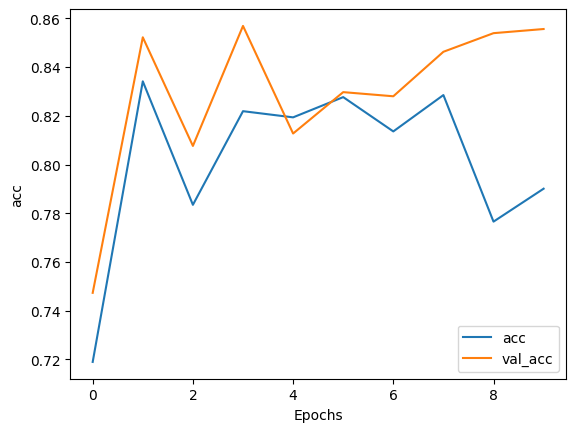

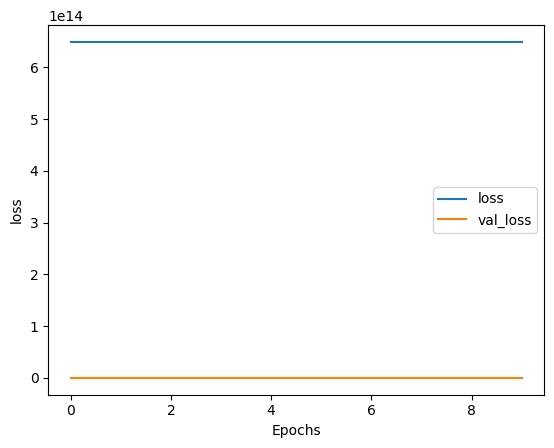

In [73]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")